## Electron Microscopy Particle Segmentation

#### Imports:

In [2]:
import torch
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

import matplotlib.pyplot as plt
import seaborn as sn

# Support libraries
import numpy as np
import pandas as pd
import itertools
import os
import random
from PIL import Image
from sklearn.metrics import jaccard_score

#### Data Preprocessing:

In [3]:
class ParticleSeg(Dataset):
    
    def __init__(self, root_dir:str, img_transforms:object=None, mask_transforms:object=None):
        
        super().__init__()
        
        self.root_dir = root_dir
        self.transforms_mask = mask_transforms
        self.transforms_img = img_transforms
        
        self.mask_dir = os.path.join(root_dir, "segmaps")
        self.img_dir = os.path.join(root_dir, "images")
        
        self.file_names = os.listdir(self.mask_dir)
        self.mask_paths = [os.path.join(self.mask_dir, mask_name) for mask_name in self.file_names]
        self.img_paths = [os.path.join(self.img_dir, img_name) for img_name in self.file_names]
   

    def __len__(self):
        
        return len(self.file_names)

    def __getitem__(self, ix:int):

        seed = np.random.randint(2022)
        random.seed(seed)
        torch.manual_seed(seed)

        mask_path, img_path = self.mask_paths[ix], self.img_paths[ix]

        mask, img = Image.open(mask_path), Image.open(img_path).convert('RGB')

        if self.transforms_img is not None:

            img = self.transforms_img(img)

        random.seed(seed)
        torch.manual_seed(seed)

        if self.transforms_mask is not None:

            mask = self.transforms_mask(mask)

        mask, img = mask.float(), img.float()
        
        mask[mask > 0 ] = 1
        # img = img / 255

        return img, mask

#### Data Transformations:

In [4]:
img_transforms = T.Compose([
    T.ToTensor(),
    T.GaussianBlur(5),
    T.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize((244,244)),
])


mask_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((244,244))
])

#### Generating a general dataset:

In [5]:
dataset = ParticleSeg(
    root_dir='/Users/omachrekar/My Work/EMS/Dataset/data', 
    img_transforms=img_transforms,
    mask_transforms=mask_transforms
)

#### Some Visualisation:

/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


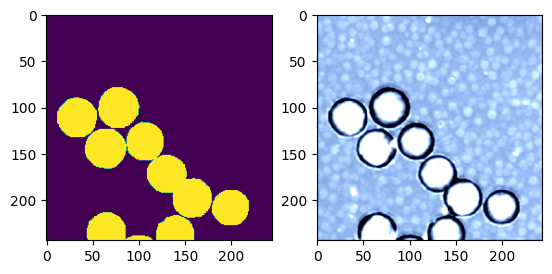

In [6]:
mask, img = dataset[8]

fig, ax = plt.subplots(nrows=1, ncols=2)

pos1 = ax[0].imshow(img.permute((1, 2, 0)))
pos2 = ax[1].imshow(mask.permute((1, 2, 0)))

#### Splitting Dataset for Training & Validation:

In [7]:
dataset_train, dataset_val = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

print(len(dataset_train), len(dataset_val))

372 93


#### Defining Dataloaders:

In [8]:
dataloader_train = DataLoader(dataset_train, batch_size = 16)
dataloader_val = DataLoader(dataset_val, batch_size = 16)

#### Model Definition:

In [9]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    return model

#### Model Training:

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = createDeepLabv3(1).to(device)
criterion =  nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

def train(model, dataloader):
    model.train()
    train_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        
        images, masks = data[0].to(device), data[1].to(device)
        out = model(images)['out']
        
        loss = criterion(out, masks)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss/ len(dataloader)

def test(model, dataloader):
    model.eval()
    test_loss = 0
    train_iou = 0
    for data in dataloader:        
        images, masks = data[0].to(device), data[1].to(device)
        out = model(images)['out']
        
        loss = criterion(out, masks)
        test_loss += loss.item()
        
        train_iou += jaccard_score(masks.detach().cpu().flatten().numpy(), 
                      out.detach().cpu().flatten().numpy() > 0.99)
        
    return test_loss/ len(dataloader), train_iou / len(dataloader)

train_loss_lst = []
test_loss_lst = []
for epoch in range(epochs):
    train_loss = train(model, dataloader_train)
    train_loss_lst.append(train_loss)

    val_loss, val_iou = test(model, dataloader_val)
    test_loss_lst.append(val_loss)
    
    print('Epoch [{}/{}], Train loss: {:.4f}, Val loss {:.4f}, Val IoU {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, val_iou))    

/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /Users/omachrekar/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:50<00:00, 3.34MB/s] 
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packa

Epoch [1/10], Train loss: 0.3265, Val loss 1.0021, Val IoU 0.5863


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [2/10], Train loss: 0.1798, Val loss 0.2007, Val IoU 0.8361


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [3/10], Train loss: 0.1382, Val loss 0.1360, Val IoU 0.8554


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [4/10], Train loss: 0.1058, Val loss 0.1002, Val IoU 0.8813


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [5/10], Train loss: 0.0885, Val loss 0.0822, Val IoU 0.8996


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [6/10], Train loss: 0.0773, Val loss 0.0764, Val IoU 0.9021


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [7/10], Train loss: 0.0693, Val loss 0.0764, Val IoU 0.9137


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [8/10], Train loss: 0.0666, Val loss 0.0705, Val IoU 0.9198


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [9/10], Train loss: 0.0719, Val loss 0.0788, Val IoU 0.8718


/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/omachrekar/miniforge3/envs/work/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Epoch [10/10], Train loss: 0.0671, Val loss 0.0839, Val IoU 0.8972


#### Training and Validation Loss Visualisation:

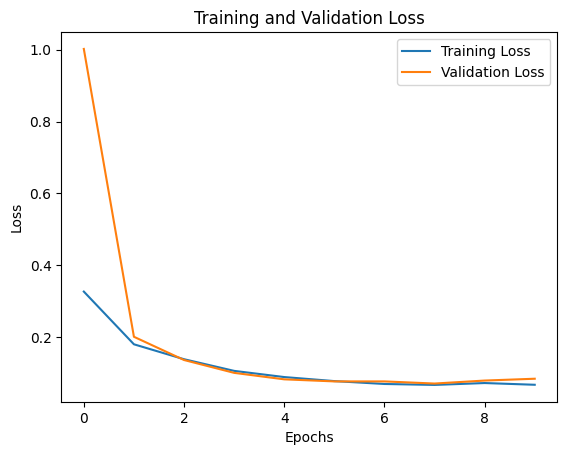

In [11]:
plt.plot(train_loss_lst, label='Training Loss')
plt.plot(test_loss_lst, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

#### Segmentation in pictures:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


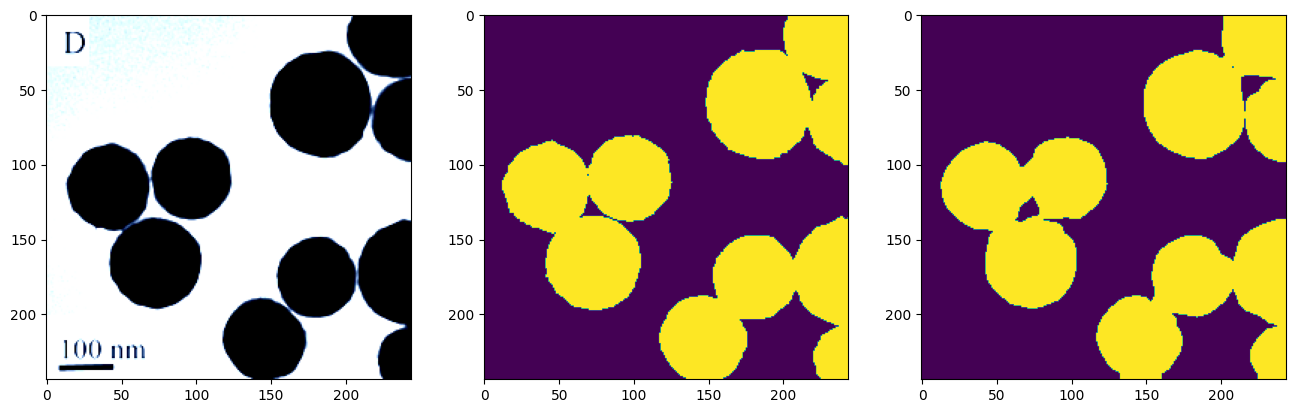

In [15]:
dataiter = iter(dataloader_train)
images, masks = next(dataiter)

images = images.to(device)
output = model(images)['out']

image_indx = 15
thresh_img = output[image_indx].cpu().detach() > 0.999

fig, axs = plt.subplots(1, 3, figsize=(16,9))
axs[0].imshow(images[image_indx].cpu().permute((1, 2, 0)))
axs[1].imshow(masks[image_indx].cpu().permute((1, 2, 0)))
axs[2].imshow(thresh_img.permute((1, 2, 0)))